In [76]:
import spacy
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import ndcg_score
import numpy as np
import random
from sklearn.preprocessing import normalize
random.seed(42)
import spacy
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import dspy
from nltk.stem import PorterStemmer
nltk.download('punkt')
from datasets import Dataset
nltk.download('stopwords')
from transformers import pipeline
import ast
import json
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\emiel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\emiel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [102]:
def create_category_string(category, dictionary):
    string = f"{category}: "
    
    if category in dictionary:
        category_data = dictionary[category]
        if isinstance(category_data, list):
            for item in category_data:
                for k, v in item.items():
                    if k == 'name':  
                        continue
                    if isinstance(v, list):
                        v = ', '.join(v)
                    string += f"{k}: {v} "
        elif isinstance(category_data, dict):
            for k, v in category_data.items():
                if k == 'name': 
                    continue
                if isinstance(v, list):
                    v = ', '.join(v)
                string += f"{k}: {v} "
        else:
            string += f"{category}: {category_data} "
    
    return string.strip()


def transform_dict_to_strings(data):
    result = {}

    for category in data:
        result[category] = create_category_string(category, data)

    return result


In [78]:
from transformers import pipeline
from collections import defaultdict
import re
from tqdm import tqdm

class CharacterAnonymizer:
    def __init__(self, batch_size=16):
        self.ner_pipeline = pipeline(
            "ner",
            model="Jean-Baptiste/roberta-large-ner-english",
            aggregation_strategy="simple",
            device=0 
        )
        self.batch_size = batch_size

    def normalize_name(self, name):
        name = name.lower()
        name = re.sub(r"[^a-z ]", "", name)
        return name.strip()

    def extract_names_batch(self, texts):
        ner_results_batch = self.ner_pipeline(texts)
        all_names = []
        for ner_results in ner_results_batch:
            names = [ent['word'] for ent in ner_results if ent['entity_group'] == 'PER']
            normalized = list(set(self.normalize_name(name) for name in names))
            all_names.append(normalized)
        return all_names

    def cluster_names(self, names):
        clusters = defaultdict(list)
        used = set()

        for name in names:
            if not name.strip():
                continue
            if name in used:
                continue
            parts = name.split()
            if not parts:
                continue
            key = parts[0]
            for other in names:
                if key in other and other not in used:
                    clusters[key].append(other)
                    used.add(other)
        return clusters

    def generate_name_map(self, clusters):
        name_map = {}
        for i, (key, variants) in enumerate(clusters.items(), start=1):
            tag = f"Character{i}"
            for name in variants:
                name_map[name] = tag
        return name_map

    def replace_names(self, text, name_map):
        for original in sorted(name_map.keys(), key=len, reverse=True):
            pattern = re.compile(rf'\b{re.escape(original)}\b', re.IGNORECASE)
            text = pattern.sub(name_map[original], text)
        return text

    def anonymize_batch(self, texts):
        anonymized_texts = []

        for i in tqdm(range(0, len(texts), self.batch_size), desc="Anonymizing"):
            batch = texts[i:i + self.batch_size]
            all_names = self.extract_names_batch(batch)

            for text, names in zip(batch, all_names):
                clusters = self.cluster_names(names)
                name_map = self.generate_name_map(clusters)
                anonymized = self.replace_names(text, name_map)
                anonymized_texts.append(anonymized)

        return anonymized_texts


In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer
from rank_bm25 import BM25Okapi

def build_index(embeddings, normalize_vectors=True):
    if normalize_vectors:
        return normalize(embeddings, axis=1)
    return embeddings

def get_dense_similarity(query_vector, candidate_vectors):
    if query_vector.ndim == 1:
        query_vector = query_vector.reshape(1, -1)
    
    return cosine_similarity(candidate_vectors, query_vector).flatten()

def get_bm25_scores(corpus, query, bm25=None):
    if bm25 is None:
        bm25 = BM25Okapi([doc for doc in corpus])
    return bm25.get_scores(query)

def get_relevance_scores(i, labels, data, index, k=None, method='dense', bm25=None):
    if k is None:
        k = len(labels)

    query_label = labels[i]
    matching_labels = np.where(np.array(labels) == query_label)[0]

    if method == 'dense':
        query_vector = index[i].reshape(1, -1)
        similarities = get_dense_similarity(query_vector, index)
    elif method == 'bm25':
        query_text = data[i]
        similarities = get_bm25_scores(data, query_text, bm25)
    else:
        raise ValueError("Unsupported method. Use 'dense' or 'bm25'.")

    top_k_indices = np.argsort(similarities)[::-1]
    top_k_indices = top_k_indices[top_k_indices != i][:k]

    relevance_scores = [1 if x in matching_labels else 0 for x in top_k_indices]
    ideal_relevance_scores = sorted(relevance_scores, reverse=True)

    return ideal_relevance_scores, relevance_scores

def calculate_mean_ndcg_score(labels, data, embeddings=None, method='dense'):
    if method == 'dense':
        embeddings = np.array(embeddings).astype('float32')
        index = build_index(embeddings)
        get_index = lambda: index
        bm25 = None
    elif method == 'bm25':
        index = data
        get_index = lambda: index
        bm25 = BM25Okapi([doc for doc in data])
    else:
        raise ValueError("Method must be 'dense' or 'bm25'.")

    ideal_relevance_scores = []
    relevance_scores = []

    for i in [labels.index(x) for x in list(set(labels))]:
        irs, rs = get_relevance_scores(i, labels, data, get_index(), method=method, bm25=bm25)
        ideal_relevance_scores.append(irs)
        relevance_scores.append(rs)

    return ndcg_score(np.array(ideal_relevance_scores), np.array(relevance_scores))


In [58]:
model = SentenceTransformer("nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True, device=device)
embedder = dspy.Embedder(model.encode)
# Load model directly
#from transformers import AutoTokenizer, AutoModel

#tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")


<All keys matched successfully>


In [291]:
df = pd.read_excel("data/tell_me_again_df_with_elements_v5.xlsx")

In [292]:
df = df.dropna()

In [293]:
labels = df.label.tolist()
texts = df["extracted_elements"].tolist()

In [294]:
embeddings = model.encode(texts)

KeyboardInterrupt: 

In [ ]:
ndcg_dense = calculate_mean_ndcg_score(labels, data=texts, embeddings=embeddings, method='dense')

In [69]:
ndcg_dense

np.float64(0.8288220945964656)

In [72]:
range(len(embeddings))

range(0, 58)

In [100]:
similarity_dict = dict(zip(range(len(embeddings)), get_dense_similarity(embeddings[27], embeddings)))

dict(sorted(similarity_dict.items(), key=lambda item: item[1], reverse=True)).keys()

dict_keys([27, 26, 24, 25, 23, 22, 21, 34, 35, 15, 56, 5, 16, 32, 33, 31, 7, 14, 13, 17, 57, 37, 6, 53, 36, 39, 51, 50, 55, 12, 11, 38, 43, 44, 29, 54, 19, 1, 52, 8, 0, 48, 20, 28, 41, 30, 46, 18, 49, 9, 4, 40, 47, 42, 10, 2, 3, 45])

In [295]:
from collections import defaultdict
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
import matplotlib.cm as cm 
from collections import defaultdict
import numpy as np
import json

def min_max_scale(arr):
    arr = np.array(arr)
    min_val = arr.min()
    max_val = arr.max()
    if max_val == min_val:
        return np.zeros_like(arr)  # or np.ones_like(arr), depending on use-case
    return (arr - min_val) / (max_val - min_val)

def get_similarity_scores(df, index, model):
    texts = df["extracted_elements"].tolist()
    similarities_by_key = {}

    aggregated_dict = defaultdict(list)
    for text in texts:
        category_string_dict = transform_dict_to_strings(json.loads(text))
        for key, value in category_string_dict.items():
            aggregated_dict[key].append(value)
    
    for key, values in aggregated_dict.items():
        embeddings = model.encode(values)
        target_embedding = embeddings[index]
        similarities = get_dense_similarity(target_embedding, embeddings)
        similarities_by_key[key] = min_max_scale(similarities)

    all_similarities = np.zeros_like(next(iter(similarities_by_key.values())))
    for sims in similarities_by_key.values():
        all_similarities += np.array(sims)
    similarities_by_key["overall"] = min_max_scale(all_similarities)

    return similarities_by_key

    
def make_spider(df, plot_idx, title, color, total_plots, overall_score, plots_per_row=5):
    categories = list(df.columns)[1:]
    if 'overall' in categories:
        categories.remove('overall')
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    row_idx = plot_idx // plots_per_row
    col_idx = plot_idx % plots_per_row
    n_rows = (total_plots + plots_per_row - 1) // plots_per_row
    n_cols = min(plots_per_row, total_plots)

    ax = plt.subplot(n_rows, n_cols, plot_idx + 1, polar=True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], categories, color='grey', size=8)
    ax.set_rlabel_position(0)
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], ["0", "0.2", "0.4", "0.6", "0.8", "1"], color="grey", size=7)
    plt.ylim(0, 1)

    values = df.loc[plot_idx, categories].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
    wrapped_title = "\n".join(title[i:i+20] for i in range(0, len(title), 20))
    plt.title(wrapped_title, size=18, color=color, y=1.08)

    ax.text(0.5, 0.5, f"{overall_score:.2f}", transform=ax.transAxes,
            horizontalalignment='center', verticalalignment='center',
            fontsize=24, fontweight='bold', color=color)



def visualize_similarities(df, model, target_index, top_n=4, plots_per_row=5):
    similarities_by_key = get_similarity_scores(df, index=target_index, model=model)
    
    overall_similarities = similarities_by_key["overall"]
    sorted_indices = np.argsort(overall_similarities)[::-1] 
    sorted_indices = [i for i in sorted_indices if i != target_index][:top_n]
    
    keys = [k for k in similarities_by_key.keys() if k != 'overall']
    rows = []

    for i in sorted_indices:
        title = f"{df.iloc[i]['title']} ({df.iloc[i]['language']})"
        data_row = {'group': title}
        for key in keys:
            data_row[key] = similarities_by_key[key][i]
        data_row['overall'] = overall_similarities[i]  
        rows.append(data_row)
    
    query_title = f"{df.iloc[target_index]['title']} ({df.iloc[target_index]['language']})"
    query_row = {'group': f"Query: {query_title}"}
    for key in keys:
        query_row[key] = similarities_by_key[key][target_index]
    query_row['overall'] = overall_similarities[target_index]  
    rows.insert(0, query_row)

    plot_data = pd.DataFrame(rows)

    my_dpi = 96
    width_per_plot = 500
    height_per_plot = 500
    total_plots = len(plot_data.index)
    n_rows = (total_plots + plots_per_row - 1) // plots_per_row

    fig_width = width_per_plot * min(plots_per_row, total_plots) / my_dpi
    fig_height = height_per_plot * n_rows / my_dpi

    plt.figure(figsize=(fig_width, fig_height), dpi=my_dpi)
    base_titles = plot_data['group'].apply(lambda x: x.replace('Query: ', '').split(' (')[0])
    unique_titles = base_titles.unique()
    title_to_color_idx = {title: i for i, title in enumerate(unique_titles)}
    my_palette = cm.get_cmap("tab20", len(unique_titles))

    
    for plot_idx in range(total_plots):
        base_title = base_titles.iloc[plot_idx]
        color = my_palette(title_to_color_idx[base_title])
        make_spider(df=plot_data, plot_idx=plot_idx, title=plot_data['group'][plot_idx], 
                    color=color, total_plots=total_plots,
                    overall_score=plot_data.loc[plot_idx, 'overall'],
                    plots_per_row=plots_per_row)


    plt.tight_layout()
    plt.show()

C:\Users\emiel\AppData\Local\Temp\ipykernel_13856\3923284953.py:119: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  my_palette = cm.get_cmap("tab20", len(unique_titles))


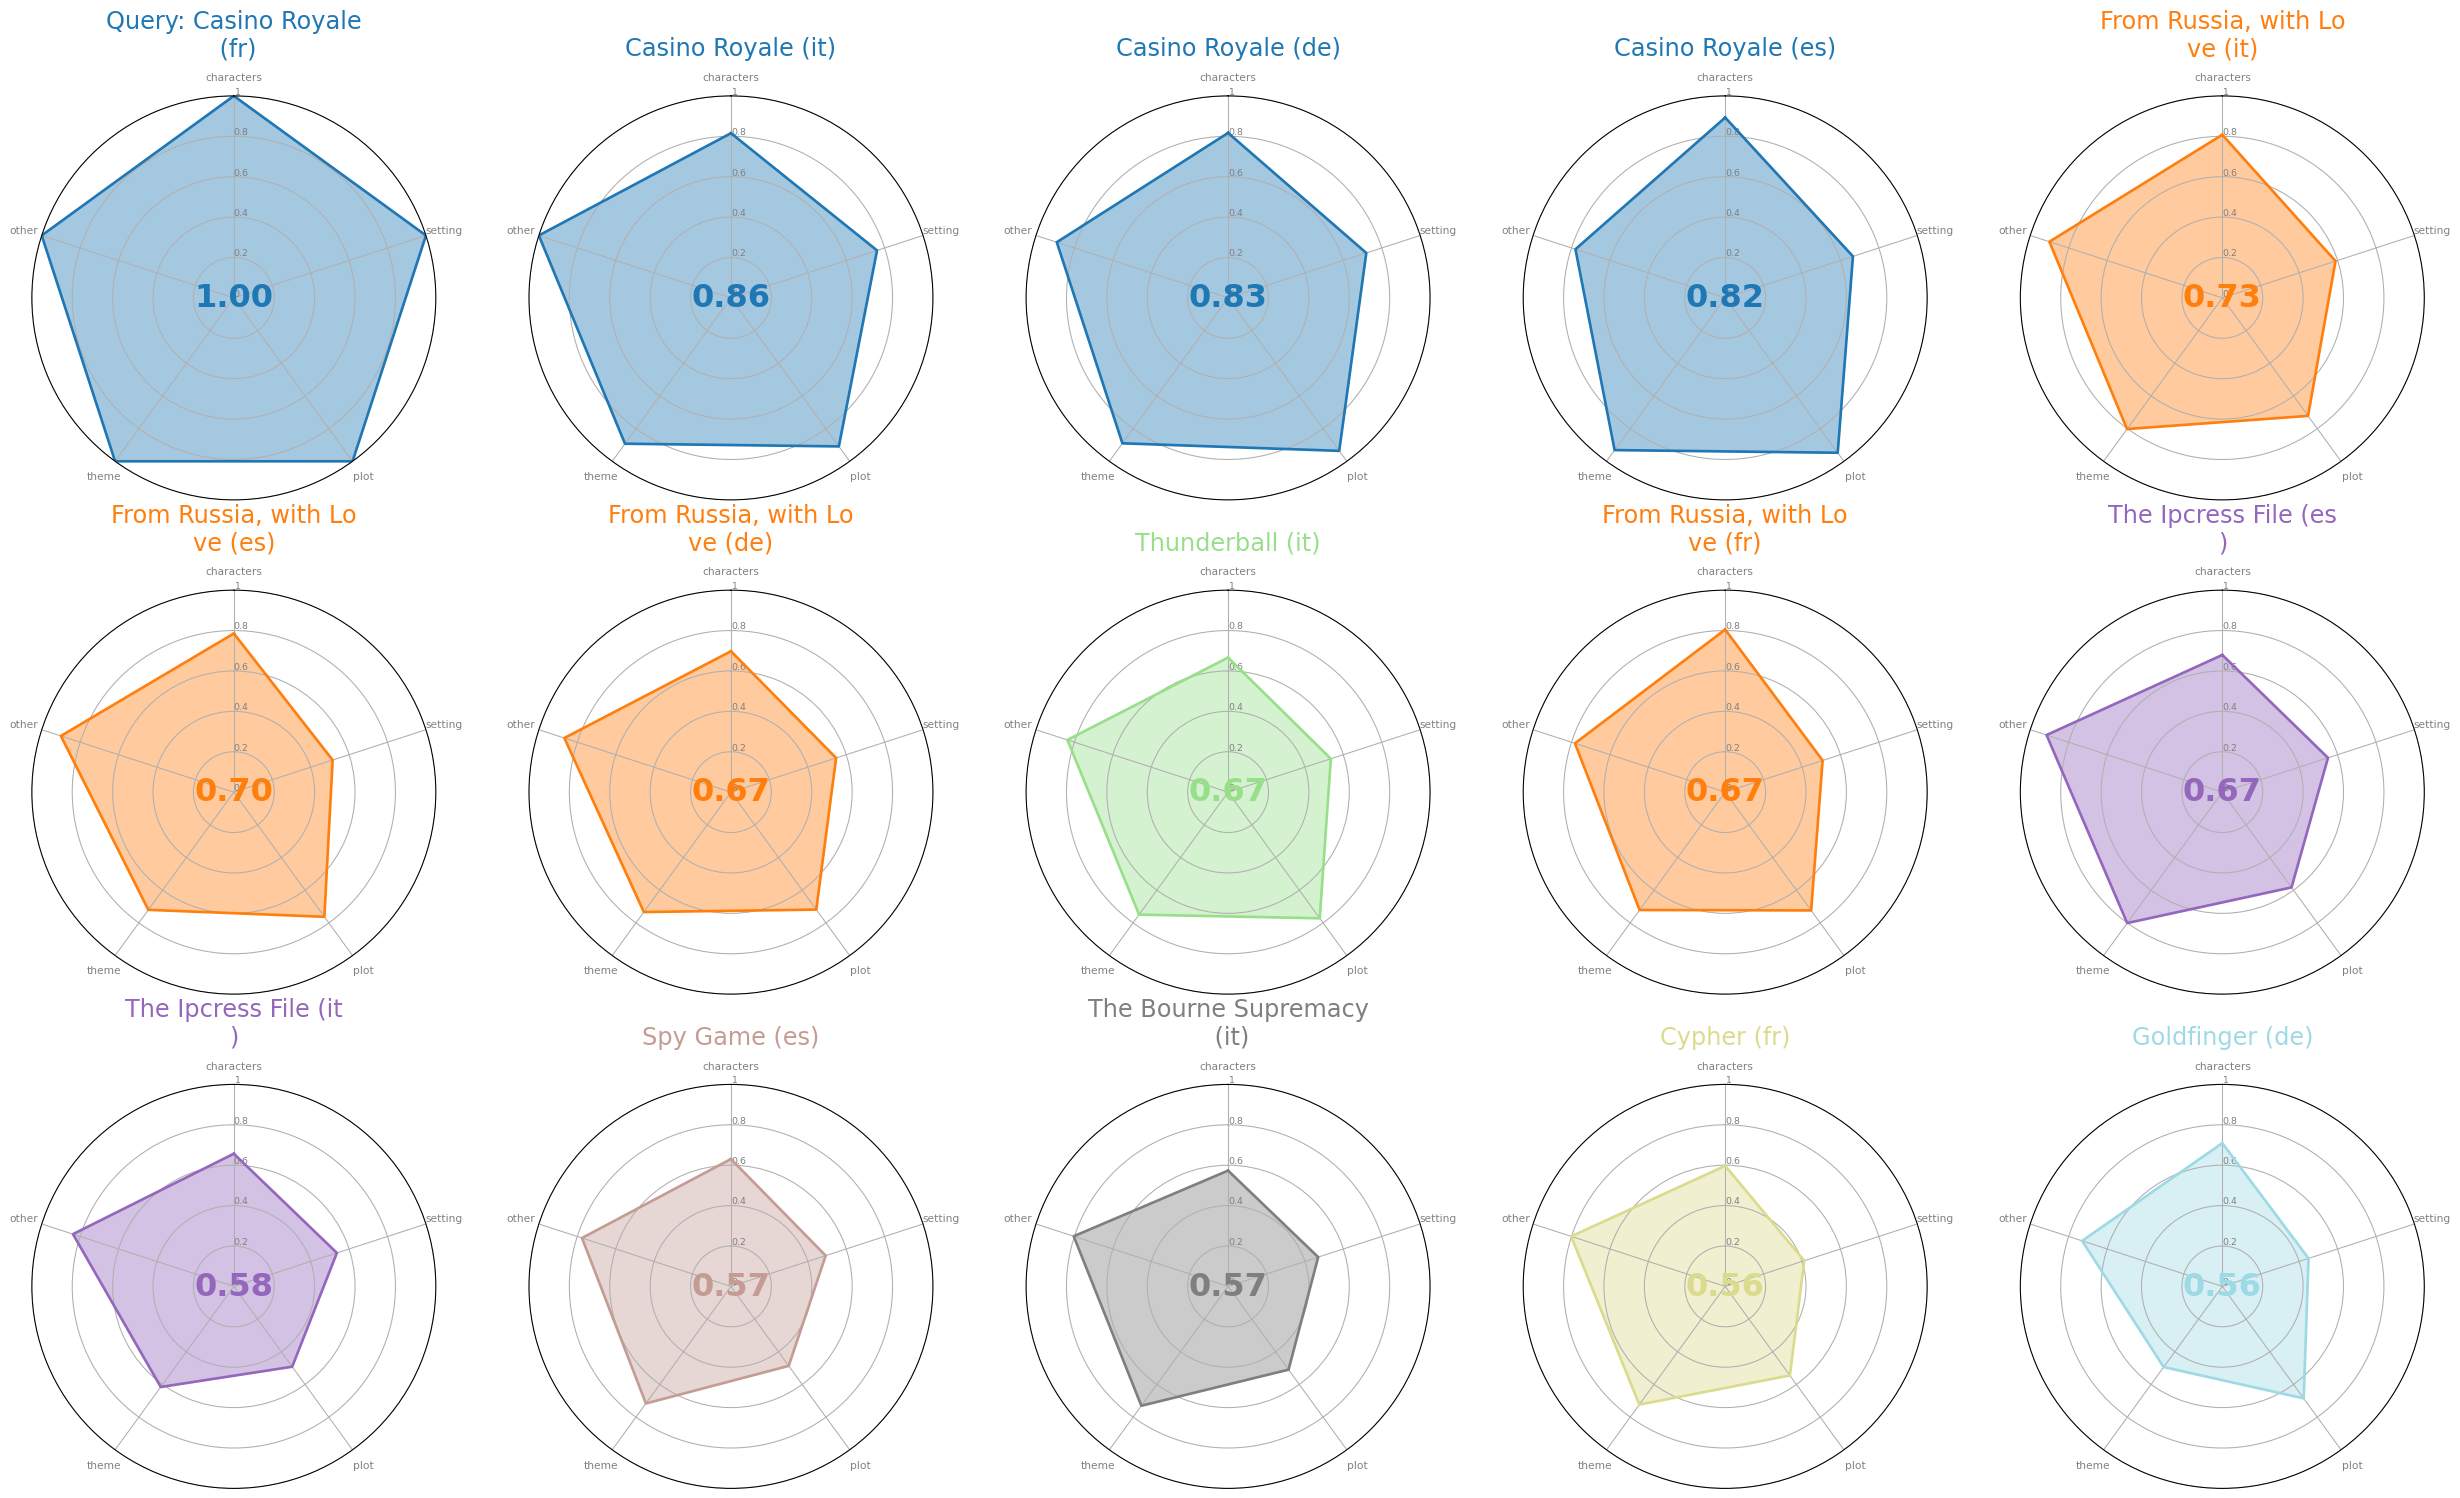

In [296]:
visualize_similarities(df, model, target_index = 53, top_n=14)